<a href="https://colab.research.google.com/github/axiezai/nl-processors/blob/main/nl-processors/gaze/colab_classify_gaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

bi-LSTM for Eye Gaze Classification
---

In [2]:
import requests, zipfile

# Download and unzip GazeCom training data in google colab:

fname = 'GazeCom.zip'
url = 'https://michaeldorr.de/smoothpursuit/GazeCom.zip'
r = requests.get(url, allow_redirects=True)

with open(fname, 'wb') as fd:
  fd.write(r.content)

with zipfile.ZipFile(fname, 'r') as zip_ref:
  zip_ref.extractall('/content/GazeCom_data')

In [3]:
import os
import natsort
import glob
import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import arff
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

Helper functions:    

In [4]:
def get_files(pattern):
    """
    Extracts file in alphanumerical order that match the provided pattern
    """
    if isinstance(pattern, list):
        pattern = os.path.join(*pattern)
        
    files = natsort.natsorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError('Pattern could not detect file(s)')
        
    return files


def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)

    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    
    print(f'Random seed {seed} has been set.')


def seed_wworker(worker_id):
    """In case dataloader is used?
    """
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """Using GPU or CPU?
    """
    device = 'cuda' if torch.cuda.is_available() else "cpu"
    if device != 'cuda':
      print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
    else:
      print("GPU is enabled in this notebook.")

    return device

In [5]:
DEVICE = set_device()
SEED = 42
set_seed(SEED)

GPU is enabled in this notebook.
Random seed 42 has been set.


### Load in GazeCom labeled data for training `[x,y]` coordinates. 

Use `scipy.io.arff` to load example file and convert to `DataFrame`:

In [6]:
raw_data = get_files('/content/GazeCom_data/gaze_arff/*/*.arff')
print(f'There are {len(raw_data)} raw eye gaze files')

labeled_data = get_files('/content/GazeCom_data/ground_truth/*/*.arff')
print(f'There are {len(labeled_data)} labeled eye gaze files')

# Load one in and examine what's inside ARFF files:
raw_arff = arff.loadarff(raw_data[0])
raw_df = pd.DataFrame(raw_arff[0])
print('Raw file:')
raw_df.head()

There are 844 raw eye gaze files
There are 844 labeled eye gaze files
Raw file:


,time,x,y,confidence
0,1000.0,590.9,5.2,1.0
1,5000.0,590.9,5.2,1.0
2,9000.0,590.6,5.0,1.0
3,13000.0,590.4,5.0,1.0
4,17000.0,589.8,5.2,1.0


In [7]:
labeled_arff = arff.loadarff(labeled_data[0])
labeled_df = pd.DataFrame(labeled_arff[0])
print('Labeled file:')
labeled_df.head()

Labeled file:


,time,x,y,confidence,handlabeller1,handlabeller2,handlabeller_final
0,1000.0,590.9,5.2,1.0,4.0,4.0,4.0
1,5000.0,590.9,5.2,1.0,4.0,4.0,4.0
2,9000.0,590.6,5.0,1.0,4.0,4.0,4.0
3,13000.0,590.4,5.0,1.0,4.0,4.0,4.0
4,17000.0,589.8,5.2,1.0,4.0,4.0,4.0


GazeCom data format: `timestamp in microseconds since start of movie (1e-6)` - `x posititon` - `y position` - `condifence value`. 

Labels (need to figure out ordering 1-4):


*   Fixation
*   Saccade
*   Smooth pursuit
*   noise



Acquisition details from paper:


*   250Hz sampling rate
*   Subjects were 45cm away from screen
*   Screen had 40cm width and 30cm height
*   Resolution is 1280x960 pixels
*   About 26.7 pixels on screen ~ 1 degree of visual angle



We hope to train a DL to classify the `<x,y>` positions.

`extract_windows` function copied over from: [Startsev 2018: Deep eye movement (EM) classifier: a 1D CNN-BLSTM model](https://github.com/MikhailStartsev/deep_em_classifier)

`izip_longest` changed  to `zip_longest` in Python3

In [8]:
def zip_equal(*args):
    """
    Iterate the zip-ed combination of @args, making sure they have the same length
    :param args: iterables to zip
    :return: yields what a usual zip would
    """
    fallback = object()
    for combination in itertools.zip_longest(*args, fillvalue=fallback):
        if any((c is fallback for c in combination)):
            raise ValueError('zip_equals arguments have different length')
        yield combination

def extract_windows(X, y, window_length,
                    padding_features=0,
                    downsample=1, temporal_padding=False):
    """
    Extract fixed-sized (@window_length) windows from arbitrary-length sequences (in X and y),
    padding them, if necessary (mirror-padding is used).
    :param X: input data; list of arrays, each shaped like (NUM_SAMPLES, NUM_FEATURES);
              each list item corresponds to one eye tracking recording (one observer & one stimulus clip)
    :param y: corresponding labels; list of arrays, each shaped like (NUM_SAMPLES,);
              each list element corresponds to sample-level eye movement class labels in the respective sequence;
              list elements in X and y are assumed to be matching.
    :param window_length: the length of resulting windows; this is the input "context size" in the paper, in samples.
    :param padding_features: how many extra samples to take in the feature (X) space on each side
                             (resulting X will have sequence length longer than resulting Y, by 2 * padding_features,
                             while Y will have sample length of @window_length);
                             this is necessary due to the use of valid padding in convolution operations in the model;
                             if all convolutions are of size 3, and if they all use valid padding, @padding_features
                             should be set to the number of convolution layers.
    :param downsample: take each @downsample'th window; if equal to @window_length, no overlap between windows;
                       by default, all possible windows with the shift of 1 sample between them will be created,
                       resulting in NUM_SAMPLES-1 overlap; if overlap of K samples is desired, should set
                       @downsample=(NUM_SAMPLES-K)
    :param temporal_padding: whether to pad the entire sequences, so that the first window is centered around the
                             first sample of the real sequence (i.e. the sequence of recorded eye tracking samples);
                             not used
    :return: two lists of numpy arrays:
                (1) a list of windows corresponding to input data (features),
                (2) a list of windows corresponding to labels we will predict.
                These can be used as input to network training procedures, for example.
    """
    res_X = []
    res_Y = []
    # iterate through each file in this subset of videos
    for x_item, y_item in zip_equal(X, y):
        # pad for all windows
        padding_size_x = padding_features
        padding_size_y = 0
        if temporal_padding:
            padding_size_x += window_length / 2
            padding_size_y += window_length / 2

        padded_x = np.pad(x_item, ((padding_size_x, padding_size_x), (0,0)), 'reflect')
        # padded_y = np.pad(y_item, ((padding_size_y, padding_size_y), (0, 0)), 'reflect')
        padded_y = np.pad(y_item, (padding_size_y, padding_size_y), 'reflect')
        
        # Extract all valid windows in @padded_x, with given downsampling and size.
        # @res_X will have windows of size @window_length + 2*@padding_features
        window_length_x = window_length + 2 * padding_features
        res_X += [padded_x[i:i + window_length_x, :] for i in
                  range(0, padded_x.shape[0] - window_length_x + 1, downsample)]
        # @res_Y will have windows of size @window_length, central to the ones in @res_X
        res_Y += [padded_y[i:i + window_length] for i in
                  range(0, padded_y.shape[0] - window_length + 1, downsample)]
    return res_X, res_Y

In [9]:
coords = []
coords.append(labeled_df[['x', 'y']].values)
labels = []
bin_labels = labeled_df['handlabeller_final'].values
# bin_labels = pd.get_dummies(labeled_df['handlabeller_final']).values
labels.append(bin_labels)
x, y = extract_windows(coords, labels, 263, padding_features=3)
print(len(x), len(y))

4746 4746


Create DataLoader for dataset:

In [10]:
# Create a custom dataset for GazeCom files:
from torch.utils.data import Dataset, DataLoader

class GazeComDataset(Dataset):
  def __init__(self, data_list, window_size = 129, pad_num = 3, transforms = None):
    self.data_list = data_list
    self.df = pd.DataFrame(arff.loadarff(data_list[0])[0])
    self.win_size = window_size
    self.pad_size = pad_num
    # self.labels = pd.get_dummies(self.df['handlabeller_final']).values
    self.labels = self.df['handlabeller_final'].values
    self.transforms = transforms
    coords = []
    labels = []
    coords.append(self.df[['x', 'y']].values)
    labels.append(self.labels)
    self.window_x, self.window_y = extract_windows(coords, labels, window_length=window_size, padding_features=pad_num)

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    # Return 1 sample and label according to idx:
    # print(self.data_list[idx])
    data = pd.DataFrame(arff.loadarff(self.data_list[idx])[0])
    xy_timeseries = data[['x', 'y']].values
    # bin_label = pd.get_dummies(data['handlabeller_final']).values
    bin_label = data['handlabeller_final'].values
    coords = []
    labels = []
    coords.append(xy_timeseries)
    labels.append(bin_labels)
    winx, winy = extract_windows(coords, labels, window_length=self.win_size, padding_features=self.pad_size)
    rand_index = torch.randint(low=0, high=min(len(winx), len(winy)), size=(1,))
    # print(len(winx), len(winy), rand_index)
    return winx[rand_index], winy[rand_index]

Try to iterate through a `DataLoader`:

In [11]:
testing_split = 0.2
batch_size = 1
shuffle = True

# create dataset:
dataset = GazeComDataset(labeled_data)
dataset_size = len(dataset)
print(f'Dataset has {dataset_size} .arff files')
# indices = list(range(dataset_size))
# split = int(np.floor(testing_split * dataset_size))

# DataLoader and split:
split = int(dataset_size * testing_split)
# train_indices, test_indices = indices[split:], indices[:split]
train_set, test_set = torch.utils.data.random_split(dataset, [dataset_size - split, split])
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Iterate through DataLoader and view an example:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
# labels do not get padded!
print(f"Labels batch shape: {train_labels.size()}")

Dataset has 844 .arff files
Feature batch shape: torch.Size([1, 135, 2])
Labels batch shape: torch.Size([1, 129])


### Create DL model:

Layers: 

*   Input: 135 (windows x features (x,y coordinatets))
*   Convolution 1: [135x3, 32@3, 133x32], batch normalization + ReLu
*   Convolution 2: [133x32, 16@3, 131x16] .3 dropout, batch normalization + ReLu
*   Convolution 3: [131x16, 8@3, 129x8] .3 dropout, batch normalization + ReLu
*   TTDLinear: 0.3 dropout, 32,  129x32 output
*   BLSTM: tanh activation. 129x32 output
*   TTDLLinear: + softmax: 129x4 classes


In [28]:
# We need a sequence wise module for time distributed fully connected layer
class DistributedLinear(nn.Module):
  def __init__(self, sequence_length, hidden_size):
    super(DistributedLinear, self).__init__()
    self.fc_list = nn.ModuleList()
    self.seq_length = sequence_length
    for j in range(self.seq_length):
      fc = nn.Linear(self.seq_length, hidden_size)
      self.fc_list.append(fc)

  def forward(self, x):
    lst = []
    for j in range(self.seq_length):
      # print(x[:, j:j+1,:].shape)
      lst.append(self.fc_list[j](x[:, j:j+1,:]))
      # lst.append(self.fc_list[j](x[:,:,j:j+1]))
    out = torch.cat(lst, dim=1)
    return out


class BLSTM(nn.Module):
  def __init__(self, layers, in_sequences, device, kernel_size = 3, hidden_size=16, drop_p = 0.3):
    super(BLSTM, self).__init__()
    self.n_layers = layers
    self.n_seqs = in_sequences
    self.device = device
    self.kernel_size = kernel_size
    self.hidden_size = hidden_size
    self.batch_norm1 = nn.BatchNorm1d(32)
    self.batch_norm2 = nn.BatchNorm1d(16)
    self.batch_norm3 = nn.BatchNorm1d(8)
    self.conv1 = nn.Conv1d(in_channels = 2, out_channels = 32, kernel_size = self.kernel_size)
    self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 16, kernel_size = self.kernel_size)
    self.conv3 = nn.Conv1d(in_channels = 16, out_channels = 8, kernel_size = self.kernel_size)
    self.fc1   = DistributedLinear(8, 32)
    self.fc2   = DistributedLinear(32, 4)
    self.lstm  = nn.LSTM(input_size = 32, hidden_size= hidden_size, num_layers=16, batch_first=False, bidirectional = True)
    self.dropout = nn.Dropout(drop_p)
    self.hidden = (torch.randn(2 * 16, 1, self.hidden_size).double().to(self.device),
              torch.randn(2 * 16, 1, self.hidden_size).double().to(self.device))
  
  def forward(self, input):
    """
    Input is a window length x batch size tensor
    """
    x = input.view(1, 2, self.n_seqs) # reshape for cov?
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = self.dropout(x)
    x = self.batch_norm3(x)
    x = F.relu(x)
    x = x.permute(2, 0, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = F.relu(x)
    output, (hn, cn) = self.lstm(x, self.hidden)
    x = torch.tanh(output)
    x = self.fc2(x)
    return x.permute(1,2,0)

In [29]:
gazecom_bLSTM = BLSTM(1, 135, device = DEVICE)
gazecom_bLSTM = gazecom_bLSTM.double().to(DEVICE)
logits = gazecom_bLSTM(train_features.to(DEVICE)) # Permuted for CrossEntropyLoss: minibatches x classes x seq

loss = nn.CrossEntropyLoss()
train_labels = train_labels.long().to(DEVICE)
output = loss(logits, train_labels-1)
print(output)

tensor(1.2973, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLoss2DBackward>)


### Training:

Create training and testing functions:

In [32]:
def train(model, device, train_dataloader, epochs, learning_rate):
  """
  """
  # define hyperparameters
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # prep lists
  train_loss, train_acc = [], []

  # training loop:
  for epoch in tqdm(range(epochs), desc= 'Epochs'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    steps = 0

    # iterate over training data loader:
    for idx, data in enumerate(train_dataloader):
      eye_coords, labels = data
      eye_coords, labels = eye_coords.to(device), labels.long().to(device)

      optimizer.zero_grad()
      out_prob = model(eye_coords)
      # Labels needs to be converted to dtype `long` and -1 for C-1 classes
      labels = labels -1
      loss = criterion(out_prob, labels)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy:
      _, predicted = torch.max(out_prob.squeeze(), 0)
      total += labels.size(1)
      correct += (predicted == labels).sum().item()

    # print every few epochs:
    if epoch % 2 == 0:
      print(f'Epoch: {epoch}, training loss: {loss.item():.2f}, training accuracy: {correct/total:.2f}.')
  
    train_loss.append(running_loss/len(train_dataloader))
    train_acc.append(correct/total)

  return train_loss, train_acc

def test(model, device, test_dataloader):
  """
  """
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
      eye_coords, labels = data
      eye_coords, labels = eye_coords.to(device), labels.long().to(device)
      labels = labels - 1
      out_prob = model(eye_coords)
      
      _, predicted = torch.max(out_prob.squeeze(), dim = 0)
      total += labels.size(1)
      correct += (predicted == labels).sum().item()

    acc = 100 * (correct/total)
    return acc

Train on GazeCom:

Training on cuda


Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0, training loss: 1.71, training accuracy: 0.77.
Epoch: 2, training loss: 0.50, training accuracy: 0.75.
Epoch: 4, training loss: 0.35, training accuracy: 0.76.
Epoch: 6, training loss: 0.59, training accuracy: 0.75.
Test accuracy: 70.127 after training for 8 epochs.


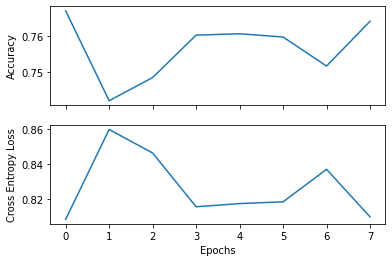

In [33]:
# Hyperparameters
learning_rate = 0.001
epochs = 5
print(f'Training on {DEVICE}')

gazecom_bLSTM.to(DEVICE)
train_loss, train_acc = train(gazecom_bLSTM, DEVICE, train_loader, epochs, learning_rate)
test_accuracy = test(gazecom_bLSTM, DEVICE, test_loader)
print(f'Test accuracy: {test_accuracy:.3f} after training for {epochs} epochs.')

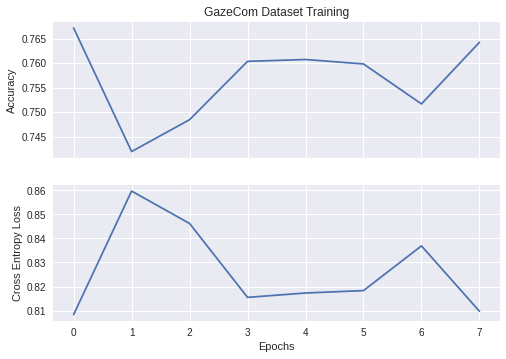

In [37]:
# plot accuracy:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(np.arange(epochs), train_acc)
ax1.set_ylabel('Accuracy')
ax1.set_title('GazeCom Dataset Training')
ax2.plot(np.arange(epochs), train_loss);
ax2.set_xlabel('Epochs');
ax2.set_ylabel('Cross Entropy Loss');

Save model?

In [ ]:
torch.save(gazecom_bLSTM.state_dict(), '/content/blstm_weights.pth'

## Study Forrest

Get Study Forrest eye gaze dataset:

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [132]:
from scipy.signal import decimate

def load_studyforrest(sub, q=4, datapath = '/content/StudyForrest_data/'):
  """
  sub (str): which subject to load
  # q = downsampling factor, default: 1000Hz to 250Hz
  """
  filename = f'{datapath}sub-{sub}_ses-movie_task-movie_run-1_recording-eyegaze_physio.tsv.gz'
  data = pd.read_csv(
      filename, sep='\t', names = ['x', 'y', 'dil', 'frame']
  )
  coords = data[['x', 'y']].values
  return decimate(coords, q=q, axis=0, ftype='fir')
  # return data[['x', 'y']].values

In [145]:
data = load_studyforrest('01')
print(f'Data loaded and downsampled to {len(data)} time points')

Data loaded and downsampled to 225508 time points


In [134]:
x, y = extract_windows(coords, labels, 129, padding_features=3)
print(len(x), len(y))
print(x[0].shape, y[0].shape)

4880 4880
(135, 2) (129,)


Predictions with trained bLSTM:

In [141]:
win_num = 24
win_coords = torch.from_numpy(x[win_num]).double().to(DEVICE)
logits = gazecom_bLSTM(win_coords)
_, predicted = torch.max(logits.squeeze(), dim = 0)

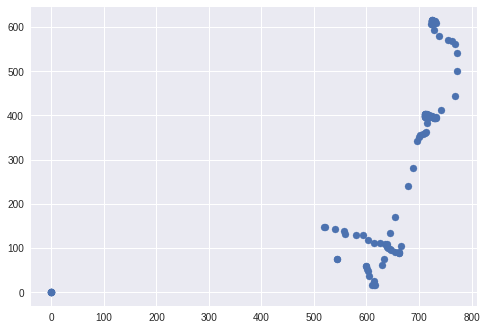

In [142]:
plt.scatter(x[win_num][:,0],x[win_num][:,1])

In [143]:
# 0 = fixation
# 1 = saccade
# 2 = pursuit
# 4 = noise/blinks
predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')